# Model Selection

### Import and Setup

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform


df = pd.read_csv("github_issues_processed.csv")

### Target number of days to resolution

In [ ]:
# Log transform n_days_to_resolution
df['n_days_to_resolution'] = np.log1p(df['n_days_to_resolution'])

# Separate features and target
X = df.drop(columns=["n_days_to_resolution"])
y = df["n_days_to_resolution"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)


### Cross Validation

In [5]:
n_jobs = 8

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        random_state=42,
        n_jobs=n_jobs
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=100, 
        learning_rate=0.1, 
        random_state=42,
        n_jobs=n_jobs
    ),
}

# Use same core count for CV
for name, model in models.items():
    print(f"Training {name} using {n_jobs} cores...")
    model_results = {}
    for metric_name, metric in scoring_metrics.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric, n_jobs=-1)
        if metric_name in ['mae', 'mse']:
            model_results[metric_name] = -scores.mean()
        else:
            model_results[metric_name] = scores.mean()
        model_results[f'{metric_name}_std'] = scores.std()
    results[name] = model_results

# Display results
results_df = pd.DataFrame(results).T
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS (5-fold)")
print("="*80)
print(results_df.round(4))

TypeError: GradientBoostingRegressor.__init__() got an unexpected keyword argument 'n_jobs'

In [8]:
# Define model
gbr = GradientBoostingRegressor(random_state=42)

# Hyperparameter distributions
param_dist = {
    "n_estimators": randint(20, 50),
    "learning_rate": uniform(0.01, 0.2),
    "max_depth": randint(3, 7),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
    "subsample": uniform(0.7, 0.3)
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=20,  # number of random combinations to try
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=8,
    random_state=8,
    verbose=1
)

# Fit
random_search.fit(X_train, y_train)

# Best model
best_gbr = random_search.best_estimator_
print("Best params:", random_search.best_params_)
print("Best CV MAE:", -random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'learning_rate': np.float64(0.19854603250280817), 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 49, 'subsample': np.float64(0.9935257449144032)}
Best CV MAE: 1.1932729258824544


In [ ]:
resolution_days_gbr = GradientBoostingRegressor(
    learning_rate=np.float64(0.19854603250280817),
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=49,
    subsample=np.float64(0.9935257449144032)
)

resolution_hours_gbr.fit(X_train, y_train)

y_pred = resolution_hours_gbr.predict(X_test)

# Accuracy
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f} hours")
print(f"RMSE: {rmse:.2f} hours")
print(f"R²:   {r2:.3f}")

MAE:  1.08 hours
RMSE: 1.39 hours
R²:   0.726


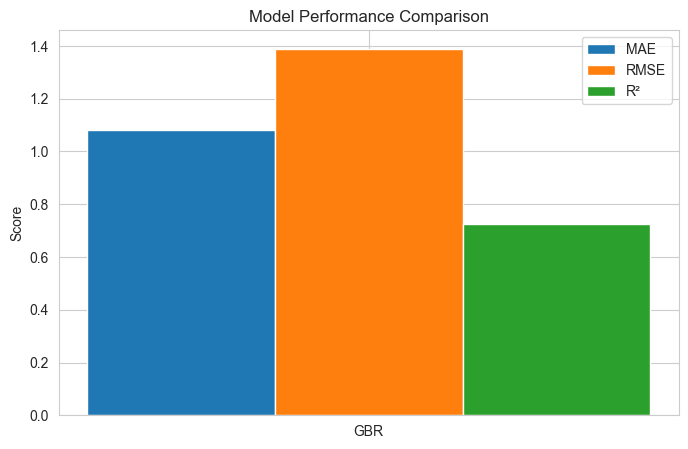

In [14]:
metrics = {
    "GBR": {"MAE": 1.08, "RMSE": 1.39, "R2": 0.726}
}

# Convert to lists for plotting
models = list(metrics.keys())
mae = [metrics[m]["MAE"] for m in models]
rmse = [metrics[m]["RMSE"] for m in models]
r2 = [metrics[m]["R2"] for m in models]

x = range(len(models))

plt.figure(figsize=(8,5))
plt.bar(x, mae, width=0.25, label="MAE")
plt.bar([i+0.25 for i in x], rmse, width=0.25, label="RMSE")
plt.bar([i+0.50 for i in x], r2, width=0.25, label="R²")
plt.xticks([i+0.25 for i in x], models)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()

TypeError: unsupported format string passed to list.__format__

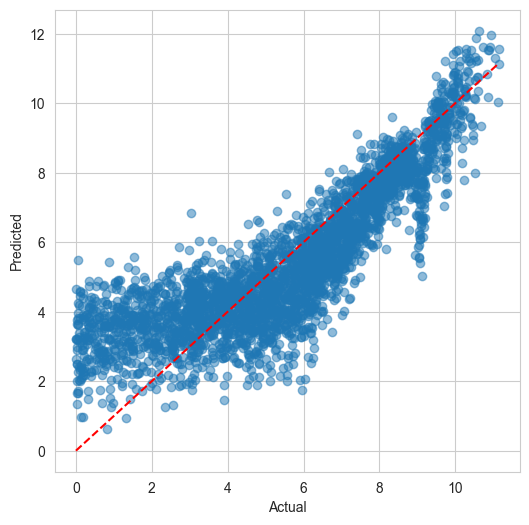

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual\nMAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}")
plt.show()

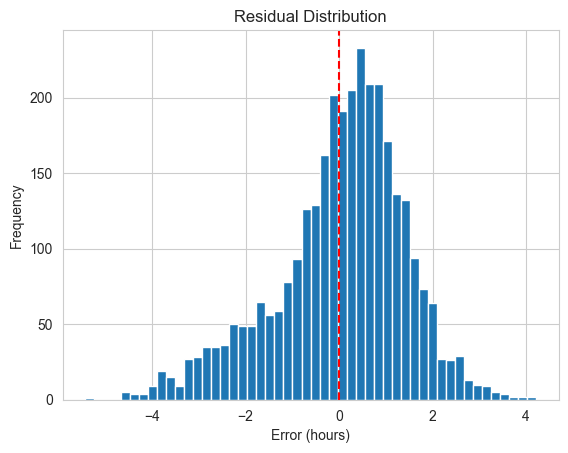

In [13]:
residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Error (hours)")
plt.ylabel("Frequency")
plt.show()

In [61]:
# Define model
ridge = Ridge(random_state=42, max_iter=10000)

# Hyperparameter grid for alpha
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # consistent with your metric
    cv=5,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Best model
best_ridge = grid_search.best_estimator_
print("Best alpha:", grid_search.best_params_)
print("Best CV MAE:", -grid_search.best_score_)

Best alpha: {'alpha': 10}
Best CV MAE: 1.6555518920274863


In [62]:
param_grid = {'alpha': [5, 7.5, 10, 12.5, 15]}

ridge = Ridge(max_iter=10000, random_state=42)
grid = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best CV MAE:", -grid.best_score_)

Best alpha: {'alpha': 10}
Best CV MAE: 1.6555518920274863


In [63]:
best_ridge = Ridge(alpha=7.5, max_iter=10000, random_state=42)
best_ridge.fit(X_train, y_train)

y_pred = best_ridge.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

Test MAE: 1.6332126981429136


                          feature  coefficient
794                     tfidf_761    -2.564747
5                    created_year    -1.912578
480                     tfidf_447    -1.870542
9                     closed_year     1.837576
750                     tfidf_717    -1.730054
1432  has_label_name_needs-triage    -1.706847
1426         has_label_name_stale     1.681238
796                     tfidf_763     1.632382
967                     tfidf_934    -1.612952
222                     tfidf_189    -1.575945


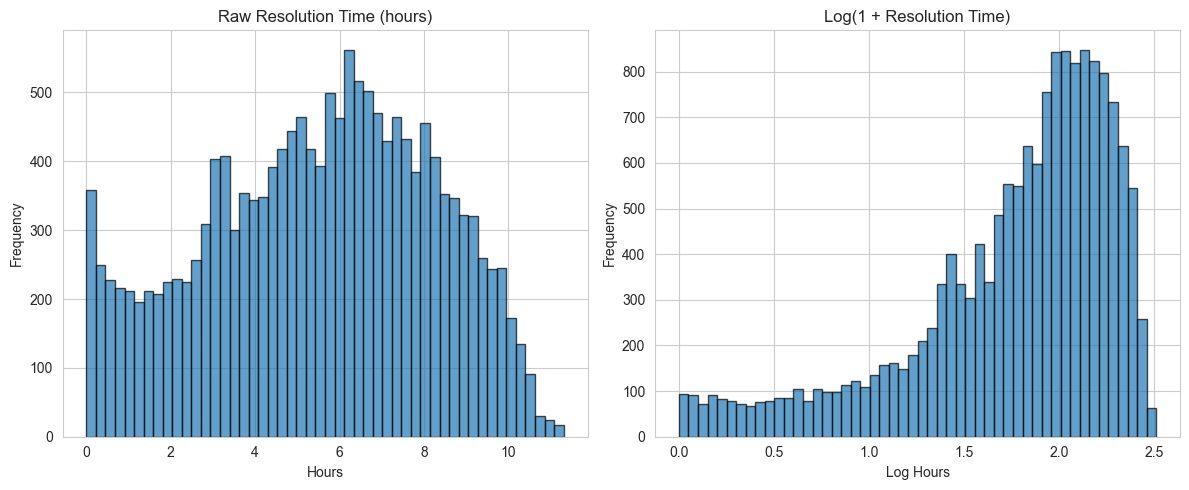

In [68]:
# Raw distribution
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(y, bins=50, edgecolor='k', alpha=0.7)
plt.title("Raw Resolution Time (hours)")
plt.xlabel("Hours")
plt.ylabel("Frequency")

# Log-transformed
plt.subplot(1,2,2)
plt.hist(np.log1p(y), bins=50, edgecolor='k', alpha=0.7)
plt.title("Log(1 + Resolution Time)")
plt.xlabel("Log Hours")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [69]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

best_lasso = Lasso(alpha=7.5, max_iter=10000, random_state=42)
best_lasso.fit(X_train, y_train_log)

y_pred_log = best_lasso.predict(X_test)
y_pred = np.expm1(y_pred_log)   # back-transform to hours

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f} hours")
print(f"RMSE: {rmse:.2f} hours")
print(f"R²:   {r2:.3f}")

MAE:  2.34 hours
RMSE: 2.77 hours
R²:   -0.084
